In [14]:
### Load PPS model
%run ./PPS_model.ipynb

In [15]:
### Load experimental data (Di Cosmo et al., 2017)

HCdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='HC') 
SCZdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='SCZ') 
SPQdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='high spq') 
LSPQdata = pd.read_excel (r'PPS_data_SCZ_SPQ.xlsx',sheet_name='low spq') 

sets = [HCdata,SCZdata,SPQdata,LSPQdata]
RTdata = []

for i in sets:
    subjects = i['Subject'].unique()
    delays = i[(i['Sound']=='Loom')&(i['Cond'] != 'Loom_NO')]['Cond'].unique()
    delays = np.delete(delays,np.where(delays=='Loom_-700')[0])
    idx = [3,4,0,1,2]
    delays = delays[idx]
    RTs = []
    
    for s in subjects:
        meanRTs = []
        for t in delays:
            RT = i[(i['Subject'] == s)&(i['Cond'] == t)]['Rtpul']           
            meanRTs.append(np.mean(RT))
        RTs.append(meanRTs)
    RTdata.append(RTs)
    
HC_RTs = np.asarray(RTdata[0])
SCZ_RTs = np.asarray(RTdata[1])
SPQ_RTs = np.asarray(RTdata[2])
LSPQ_RTs = np.asarray(RTdata[3])

In [16]:
def Fw (Wt_0,Wa_0,Bt_0,Ba_0,k1,k2,lim):
    #k1 = 10
    #k2 = 700
    alpha = 0.9

    # Tactile connections
    Bt = np.ones((Mt,Nt))*Bt_0
    Wt = np.ones((Mt,Nt))*Wt_0

    # Visual connections
    Ba = np.zeros((Ma,Na))
    Wa = np.zeros((Ma,Na))

    #lim = 20

    for i in range(Ma):
        for j in range(Na):
            if (xa[i]<lim) & (ya[j]<20):
                D = 0
            else: 
                D = distance.euclidean((xa[i],ya[j]),(lim,ya[j]))              
            Ba[i,j] = alpha*Ba_0*np.exp(- D/k1)+(1-alpha)*Ba_0*np.exp(- D/k2)
            Wa[i,j] = alpha*Wa_0*np.exp(- D/k1)+(1-alpha)*Wa_0*np.exp(- D/k2)
    return Wt,Wa,Bt,Ba

## Feedback inputs

# Tactile area
def bt(z,Bt):
    bt = np.multiply(Bt,z)
    return bt

# Auditory area
def ba(z,Ba):
    ba = np.multiply(Ba,z)
    return ba


In [18]:
## Experiment Function

def boundaryexperimentrun(a_distances,time,b,pr,k1,k2,lim):
    
    Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5,k1,k2,lim)
    dt = 0.4
    timesteps = int(time/dt)
    ndist = len(a_distances)
    
    RTs = np.zeros(ndist)
    ZTs = np.zeros((Mt,Nt,ndist))
    ZAs = np.zeros((Ma,Na,ndist))
    
    ti = PHIt(0) 
    PrBa = prun(Ba,pr)
    PrWa = prun(Wa,pr*2.6)
    dtau = dt/tau
    
    qt = np.zeros((Mt,Nt,timesteps+1,ndist))
    ut = np.zeros((Mt,Nt,timesteps+1,ndist))
    zt = np.zeros((Mt,Nt,timesteps+1,ndist))
    pt = np.zeros((Mt,Nt,timesteps+1,ndist))

    qa = np.zeros((Ma,Na,timesteps+1,ndist))
    ua = np.zeros((Ma,Na,timesteps+1,ndist))
    za = np.zeros((Ma,Na,timesteps+1,ndist))
    pa = np.zeros((Ma,Na,timesteps+1,ndist))

    qm = np.zeros((timesteps+1,ndist))
    um = np.zeros((timesteps+1,ndist))
    zm = np.zeros((timesteps+1,ndist))
    pm = np.zeros((timesteps+1,ndist))
    
    ZT = np.zeros((1,timesteps+1,ndist))
    
    for d in range(ndist):
        xa_0 = a_distances[d] # How far the sound is presented.     
        ai = PHIa(0,xa_0) # Generates an auditory input

        for i in range(timesteps):    
            # Tactile activity
            ut[:,:,i+1,d] = ti+LIt(zt[:,:,i,d])+bt(zm[i,d],Bt)
            qt[:,:,i+1,d] = qt[:,:,i,d] + dtau*(-qt[:,:,i,d]+ut[:,:,i,d])
            pt[:,:,i+1,d] = psit(qt[:,:,i,d],b)
            zt[:,:,i+1,d] = pt[:,:,i,d]*np.heaviside(pt[:,:,i,d],0)

            ZT[0,i+1,d] = np.sum(zt[:,:,i,d])

            # Auditory activity
            ua[:,:,i+1,d] = ai+LIa(za[:,:,i,d])+ba(zm[i,d],PrBa) 
            qa[:,:,i+1,d] = qa[:,:,i,d] + dtau*(-qa[:,:,i,d]+ua[:,:,i,d])
            pa[:,:,i+1,d] = psia(qa[:,:,i,d],b)
            za[:,:,i+1,d] = pa[:,:,i,d]*np.heaviside(pa[:,:,i,d],0)

            # Multisensory activity
            um[i+1,d] = np.sum(np.multiply(Wt,zt[:,:,i,d])) + np.sum(np.multiply(PrWa,za[:,:,i,d]))
            qm[i+1,d] = qm[i,d] + dtau*(-qm[i,d]+um[i,d])
            pm[i+1,d] = psim(qm[i,d])
            zm[i+1,d] = pm[i,d]*np.heaviside(pm[i,d],0)    
        RT = np.argmax(zt[19,9,:,d]>0.9)*dt
    
        RTs[d] = RT
        ZMs = zm        
        ZTs[:,:,d] = zt[:,:,timesteps,d]
        ZAs[:,:,d] = za[:,:,timesteps,d]   
    return RTs,ZMs,ZTs,ZAs

In [19]:
### Audio-tactile experiment simulation setup 

## Calculate distance in cms. Speaker is positioned at 100cm from the hand. 
times = np.asarray([300,800,1500,2200,2700])
timesweep = np.arange(300,2800,100)
ts = timesweep/1000
v = 30 #cm/s 
a_distances = (120 - ts*v) # distance points in cm (network coordinates)

## Simulation setup
simtime = 200 #ms 

## Synapses setup
Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,1,4)
#Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5,10,700,60) 
bi = 0
pr = 0

In [20]:
idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
edata = np.mean(HC_RTs,axis=0)

def boundaryhcmodelrun(theta):
    hcRTs,ZMs,ZTs,ZAs = boundaryexperimentrun(distances,simtime,bi,pr,theta[0],theta[1],theta[2])
    xf = hcRTs
    yf = edata
    
    m = (xf.size * np.sum(xf*yf) - np.sum(xf) * np.sum(yf)) / (xf.size*np.sum(xf*xf) - np.sum(xf) ** 2)
    bias = (np.sum(yf) - m*np.sum(xf)) / xf.size
    
    cost = np.sum(np.square(np.divide(yf-(m*xf+bias),yf)))
    
    return cost*100000

bounds=[(1,100),(500,1000),(20,80)]
boundaryhcres = differential_evolution(boundaryhcmodelrun,bounds,disp=True)

differential_evolution step 1: f(x)= 13.9373
differential_evolution step 2: f(x)= 13.9373
differential_evolution step 3: f(x)= 11.7245
differential_evolution step 4: f(x)= 11.7245
differential_evolution step 5: f(x)= 11.7245
differential_evolution step 6: f(x)= 11.7245
differential_evolution step 7: f(x)= 11.7245
differential_evolution step 8: f(x)= 11.7245
differential_evolution step 9: f(x)= 11.7245
differential_evolution step 10: f(x)= 11.7245
differential_evolution step 11: f(x)= 11.7245
differential_evolution step 12: f(x)= 11.7245
differential_evolution step 13: f(x)= 11.7245
differential_evolution step 14: f(x)= 11.7245
differential_evolution step 15: f(x)= 11.7245
differential_evolution step 16: f(x)= 11.7245
differential_evolution step 17: f(x)= 11.7245
differential_evolution step 18: f(x)= 11.7245
differential_evolution step 19: f(x)= 11.7245
differential_evolution step 20: f(x)= 11.7245
differential_evolution step 21: f(x)= 11.7245
differential_evolution step 22: f(x)= 11.72

In [21]:
print(boundaryhcres)

     fun: 11.724480785196036
 message: 'Optimization terminated successfully.'
    nfev: 1759
     nit: 38
 success: True
       x: array([ 92.81340534, 603.85053287,  25.62306456])


In [22]:
idx = [0,5,12,19,24]
distances = np.take(a_distances,idx)
hcRTs,ZMs,ZTs,ZAs = boundaryexperimentrun(distances,simtime,0,0,92.81340534,603.85053287,25.62306456)

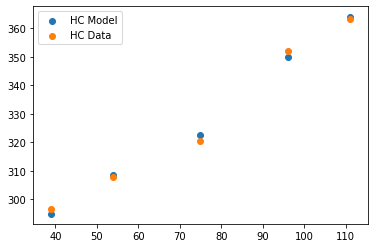

In [23]:
xf = hcRTs
yf = np.mean(HC_RTs,axis=0)    
m = (xf.size * np.sum(xf*yf) - np.sum(xf) * np.sum(yf)) / (xf.size*np.sum(xf*xf) - np.sum(xf) ** 2)
bias = (np.sum(yf) - m*np.sum(xf)) / xf.size

plt.figure(1)
plt.scatter(distances,m*hcRTs+bias,label = 'HC Model')
plt.scatter(distances,yf,label = 'HC Data')
plt.legend()

In [24]:
sczbaseline = np.asarray([m*xf+bias,yf])
np.save('sczbaseline.npy', sczbaseline)

In [25]:
print(hcRTs)
print(m,bias)

[61.6 60.8 59.2 58.4 57.6]
17.262773397429157 -699.5115771211165
